<a href="https://colab.research.google.com/github/juno2856/deeplearning/blob/master/NLP/%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Proj: 네이버 영화 리뷰 감성 분류에 SentencePiece적용하기

*   네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
*   학습된 모델로 sp_tokenize() 메소드 구현하기
*   구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
*   KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
*   (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기








In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 11.5 MB/s 


In [2]:
import matplotlib.pyplot as plt

In [3]:
import re, collections
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [4]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2022-05-23 00:19:28--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-05-23 00:19:28--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [5]:
!tar -xzvf korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7f87d57c7c90>)

In [7]:
train_data =pd.read_table('ratings_train.txt')
test_data =pd.read_table('ratings_test.txt')

In [8]:
train_data.drop_duplicates(subset = ['document'], inplace = True)
test_data.drop_duplicates(subset = ['document'], inplace = True)

In [9]:
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

True
True


In [10]:
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')

In [11]:
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

False
False


In [12]:
print('리뷰 갯수 :', len(train_data))
print('리뷰 갯수 :', len(test_data))

리뷰 갯수 : 146182
리뷰 갯수 : 49157


In [13]:
vocab_size = 8000
temp_file = '/content/korean-english-park.train.ko'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size) )

In [14]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [15]:
# sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...', '아 더빙.. 진짜 짜증나네요 목소리']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[2200 6676 7652 6684 1633 2140 6679    0    0    0    0    0    0    0]
 [ 219 2188 6676    0  269 6686   80    0   63  221    0    0    0    0]
 [  19  135 7423  205  181 7374 6676 7374 6956 6724 6961 6812 2949 6698]]


In [16]:
x_train, _, _ = sp_tokenize(s, train_data['document'])
x_test, _, _ = sp_tokenize(s, test_data['document'])

y_train = np.array(list(train_data['label'])).reshape(-1,1)
y_test = np.array(list(test_data['label'])).reshape(-1,1)

In [17]:
print(x_train.shape)
print(x_test.shape)

(146182, 140)
(49157, 140)


In [18]:
print(x_train.shape)
print(y_train.shape)

(146182, 140)
(146182, 1)


In [19]:
vocab_size = 10000
word_vector_dim = 200 # 2의 배수로 지정


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(30, return_sequences= True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(30, return_sequences= True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, None, 30)          27720     
                                                                 
 dropout (Dropout)           (None, None, 30)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 30)          7320      
                                                                 
 dropout_1 (Dropout)         (None, None, 30)          0         
                                                                 
 dense (Dense)               (None, None, 1)           31        
                                                                 
Total params: 2,035,071
Trainable params: 2,035,071
Non-

In [20]:
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [21]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
epochs = 100

In [22]:
history = model.fit(partial_x_train, partial_y_train, epochs = epochs, 
                    batch_size = 512, validation_data = (x_val, y_val), verbose = 1)

Epoch 1/100
188/188 [==============================] - 14s 32ms/step - loss: 0.5456 - accuracy: 0.7219 - val_loss: 0.4423 - val_accuracy: 0.7950
Epoch 2/100
188/188 [==============================] - 5s 27ms/step - loss: 0.4240 - accuracy: 0.8100 - val_loss: 0.4332 - val_accuracy: 0.7897
Epoch 3/100
188/188 [==============================] - 5s 27ms/step - loss: 0.4009 - accuracy: 0.8193 - val_loss: 0.4090 - val_accuracy: 0.8112
Epoch 4/100
188/188 [==============================] - 5s 27ms/step - loss: 0.3754 - accuracy: 0.8302 - val_loss: 0.4039 - val_accuracy: 0.8142
Epoch 5/100
188/188 [==============================] - 5s 27ms/step - loss: 0.3581 - accuracy: 0.8380 - val_loss: 0.4068 - val_accuracy: 0.8175
Epoch 6/100
188/188 [==============================] - 5s 27ms/step - loss: 0.3401 - accuracy: 0.8463 - val_loss: 0.4228 - val_accuracy: 0.8105
Epoch 7/100
188/188 [==============================] - 5s 28ms/step - loss: 0.3250 - accuracy: 0.8549 - val_loss: 0.4268 - val_accuracy

In [23]:
results = model.evaluate(x_test, y_test, verbose = 2)

1537/1537 - 9s - loss: 1.0851 - accuracy: 0.7993 - 9s/epoch - 6ms/step


In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

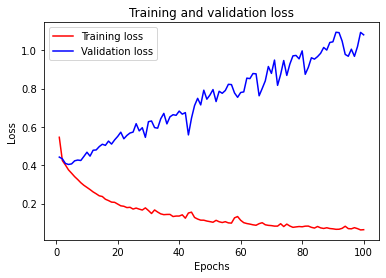

In [26]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

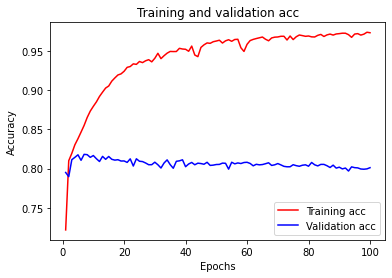

In [27]:
plt.plot(epochs, acc, 'r-', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()